In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["KERAS_BACKEND"] = "tensorflow"
seed = 42 # for testability purposes
keras.utils.set_random_seed(seed)
np.random.seed(seed)

2026-01-13 16:42:38.774262: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/enrico/ComputerVision/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
def size_to_change(img, size):
    if img.shape[0] <= img.shape[1]:
        return (256, int(np.floor(256 / img.shape[0] * img.shape[1])))
    else:
        return (int(np.floor(256 / img.shape[1] * img.shape[0])), 256)

def get_random_crop(img, cropX=224, cropY=224):
    max_x = img.shape[0] - cropX
    max_y = img.shape[1] - cropY

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = img[x: x + cropX, y: y + cropY]
    
    return crop


def load_data(url_directory, url_file, size=256, crop_dim=224, random_crop=False, central_crop=False, return_original=False):
    X = []
    y = []
    X_original = []
    
    with open(url_directory + url_file) as f:
        for line in f:
            line_split = line.split(",")
            img = cv2.imread(url_directory + line_split[0])
            img_resized = cv2.resize(img, size_to_change(img, size))
            lbl = int(line_split[2].strip())

            if random_crop:
                crop = get_random_crop(img_resized, crop_dim, crop_dim) # is it fine even for val and test?
            elif central_crop: # center crop
                img_center = (img_resized.shape[0] // 2, img_resized.shape[1] // 2)
                crop_dim_half = crop_dim // 2
                crop = img_resized[
                    img_center[0] - crop_dim_half : img_center[0] - crop_dim_half + crop_dim,
                    img_center[1] - crop_dim_half : img_center[1] - crop_dim_half + crop_dim
                    ]
            else:
                crop = img_resized[:crop_dim, :crop_dim]

            X.append(crop)
            y.append(lbl)

            if return_original:
                img_resized_original = img_resized[:size, :size]
                X_original.append(img_resized_original)

    X = np.stack(X, axis=0)
    y = np.array(y)

    if return_original:
        return X, y, np.stack(X_original, axis=0)
    else:
        return X, y

In [3]:
def color_jittering(img, brightness_range=(-60, 60), saturation_range=(-60, 60)):
    rng = np.random.default_rng()
    img_hsv = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2HSV)

    brightness = rng.integers(brightness_range[0], brightness_range[1])
    saturation = rng.integers(saturation_range[0], saturation_range[1])

    img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1] + saturation, 0, 255)
    img_hsv[:, :, 2] = np.clip(img_hsv[:, :, 2] + brightness, 0, 255)

    img_hsv = img_hsv.astype(np.uint8)

    return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

def contrast_stretching(img, linear_contrast=True, gamma_correction=False, gamma_correction_parameter=1.0):
    img_copy = img.copy()
    
    if linear_contrast:
        p_min = np.percentile(img_copy, 5)
        p_max = np.percentile(img_copy, 95)

        img_copy = np.clip((255/(p_max - p_min)) * (img_copy - p_min), 0, 255).astype(np.uint8)

    if gamma_correction:
        img_copy = np.clip(255 * np.power(img_copy/255, gamma_correction_parameter), 0, 255).astype(np.uint8)

    return img_copy

def cutout(img, size=64, color=50):
    rng = np.random.default_rng()
    img_copy = img.copy()

    x = rng.integers(0, img.shape[0] - size)
    y = rng.integers(0, img.shape[1] - size)

    img_copy[x : x + size, y : y + size] = color
    return img_copy

In [4]:
url_directory = "../GroceryStoreDataset/dataset/"

X_train = []
y_train = []

X_train, y_train, X_train_original = load_data(url_directory, "train.txt", random_crop=True, return_original=True)
X_val, y_val = load_data(url_directory, "val.txt")
X_test, y_test = load_data(url_directory, "test.txt")

In [5]:
df_classes = pd.read_csv(url_directory + "classes.csv")
df_coarse = df_classes.loc[:, ['Coarse Class Name (str)', 'Coarse Class ID (int)']].drop_duplicates().values
labels_coarse = {i: lbl for lbl, i in df_coarse}
n_classes_coarse = len(labels_coarse)
#labels_coarse

#### DATA AUGMENTATION

In [6]:
# DATA AUGMENTATION
X_train_augmented = []
y_train_augmented = []
n_crop = 1
rng = np.random.default_rng()

for idx, img in enumerate(X_train_original):
    lbl = y_train[idx]
    #print(f"shape original: {img.shape}")

    img_base = get_random_crop(img)
    X_train_augmented.append(img_base)
    y_train_augmented.append(lbl)
    #print(f"shape base: {img_base.shape}")

    if rng.integers(2) == 0: 
        img_base_flip = cv2.flip(img_base, 1)
        X_train_augmented.append(img_base_flip)
        y_train_augmented.append(lbl)
    else:
        img_base_flip = cv2.flip(img_base, 0)
        X_train_augmented.append(img_base_flip)
        y_train_augmented.append(lbl)

    #img_base_flip_both = cv2.flip(img_base, -1)
    #X_train_augmented.append(img_base_flip_both)
    #y_train_augmented.append(lbl)

    #if rng.integers(2) == 0:
    img_base_cutout = cutout(img_base_flip)
    X_train_augmented.append(img_base_cutout)
    y_train_augmented.append(lbl)

    for j in range(0, n_crop):
        img_new = get_random_crop(img)
        img_new = color_jittering(img_new)
        img_new = contrast_stretching(img_new)
        X_train_augmented.append(img_new)
        y_train_augmented.append(lbl)
        #print(f"shape new: {img_new.shape}")

        if rng.integers(2) == 0:
            img_new_flip = cv2.flip(img_new, 1) # here we are using the same image, maybe we can have different crop, color jittering etc...
            X_train_augmented.append(img_new_flip)
            y_train_augmented.append(lbl)
        else:
            img_new_flip = cv2.flip(img_new, 0) # same comment as before
            X_train_augmented.append(img_new_flip)
            y_train_augmented.append(lbl)

        #if rng.integers(2) == 0:
        img_new_cutout = cutout(img_new_flip)
        X_train_augmented.append(img_new_cutout)
        y_train_augmented.append(lbl)

        #img_new_flip_both = cv2.flip(img_new, -1) # same comment as before
        #X_train_augmented.append(img_new_flip_both)
        #y_train_augmented.append(lbl)
    #print("\n\n")

X_train_augmented = np.stack(X_train_augmented, axis=0)
y_train_augmented = np.array(y_train_augmented)
print(X_train_augmented.shape, y_train_augmented.shape)

(15840, 224, 224, 3) (15840,)


#### MODEL BUILDING

In [7]:
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Rescaling, RandomColorJitter, RandomCrop, RandomErasing,\
    RandomFlip, RandomRotation, RandomZoom, RandomTranslation, BatchNormalization, Activation, GlobalAveragePooling2D, Dropout

input_shape = X_train_augmented.shape[1:]
#crop_dim = 224

model = Sequential(
    [   
        # Input layer.
        Input(shape=input_shape),
        
        # Data Augmentation
        #RandomCrop(height=224, width=224),
        #RandomFlip(mode='horizontal'),
        #RandomRotation(factor=0.2),
        #RandomZoom(height_factor=0.2, width_factor=0.2),
        #RandomTranslation(height_factor=0.1, width_factor=0.1),
        #RandomColorJitter(brightness_factor=(0.8, 1.2), contrast_factor=(0.8, 1.2), saturation_factor=(0.8, 1.2)),
        #RandomErasing(factor=0.2),

        # Data Normalisation
        Rescaling(1./255),

        # Hidden Layers
        Conv2D(filters=32, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size = (2, 2)),

        Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size = (2, 2)),

        Conv2D(filters=128, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size = (2, 2)),

        Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(units=256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(units=n_classes_coarse, activation='softmax')
    ]
)

model.summary()

2026-01-13 16:42:56.070599: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-13 16:42:56.070653: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2026-01-13 16:42:56.070659: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2026-01-13 16:42:56.070664: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-01-13 16:42:56.070669: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: acer
2026-01-13 16:42:56.070673: I external/local_xla/xla/stream_executor/cuda/cuda_dia

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             

 Total params: 468,203 (1.79 MB)

 Trainable params: 466,731 (1.78 MB)

 Non-trainable params: 1,472 (5.75 KB)

#### MODEL TRAINING

In [8]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 32 #128
epochs = 20 

model.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model.fit(
    X_train_augmented,
    y_train_augmented,
    batch_size=batch_size,
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

2026-01-13 16:43:00.245177: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 2384363520 exceeds 10% of free system memory.


Epoch 1/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 1686s 3s/step - accuracy: 0.3673 - loss: 2.2055 - val_accuracy: 0.1959 - val_loss: 3.1621
Epoch 2/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 1665s 3s/step - accuracy: 0.5417 - loss: 1.4463 - val_accuracy: 0.2399 - val_loss: 3.0524
Epoch 3/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 1769s 4s/step - accuracy: 0.6503 - loss: 1.0893 - val_accuracy: 0.4797 - val_loss: 1.9203
Epoch 4/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 1715s 3s/step - accuracy: 0.7206 - loss: 0.8730 - val_accuracy: 0.4223 - val_loss: 2.1211
Epoch 5/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 1580s 3s/step - accuracy: 0.7604 - loss: 0.7248 - val_accuracy: 0.4966 - val_loss: 2.1106
Epoch 6/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 1571s 3s/step - accuracy: 0.8034 - loss: 0.6009 - val_accuracy: 0.3953 - val_loss: 2.6670
Epoch 7/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 1549s 3s/step - accuracy: 0.8309 - loss: 0.5204 - val_accuracy: 0.4662 - val_loss: 2.1520
Epoch 8/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 1544s 3s/step - accuracy: 0.8504 - loss: 0.4512 - 

#### MODEL EVALUATION

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - accuracy: 0.5811 - loss: 2.3196
The test loss is 2.3196, the test accuracy is 0.5811.


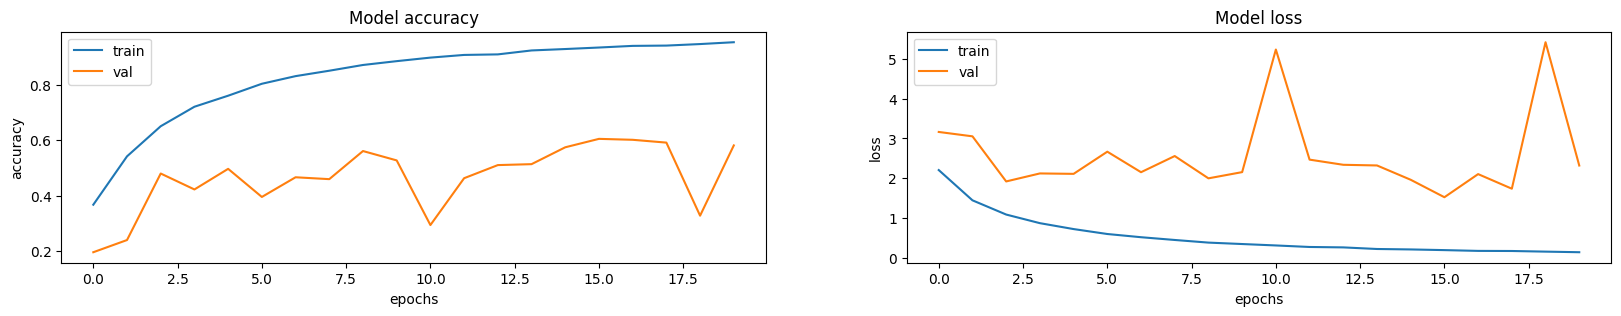

In [9]:
plt.figure(figsize=(20, 3))
for i, metric in enumerate(["accuracy", "loss"]):
    plt.subplot(1, 2, i + 1) 
    plt.plot(model.history.history[metric])
    plt.plot(model.history.history["val_" + metric])
    plt.title("Model {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train", "val"])

val_loss, val_metric = model.evaluate(X_val, y_val, verbose = 1)
print(f"The test loss is {val_loss:.4f}, the test accuracy is {val_metric:.4f}.")

In [10]:
test_loss, test_metric = model.evaluate(X_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

78/78 ━━━━━━━━━━━━━━━━━━━━ 32s 408ms/step - accuracy: 0.6471 - loss: 2.0491
The test loss is 2.0491, the test accuracy is 0.6471.
